# Constant Opacity
| Author  | Stanley A. Baronett  |
|---------|----------------------|
| Created |  12/07/2023          |
| Updated |  12/07/2023          |

See [Desmos](https://www.desmos.com/) for interactive plots of 
- [$T = P/\rho$](https://www.desmos.com/calculator/ptyevuziu7)
- [$\rho_\mathrm{mid}$](https://www.desmos.com/calculator/ubtsqj1ltb)
- [$\rho(\theta)$](https://www.desmos.com/calculator/marlugmhhr)

In code units,
\begin{align*}
  T(r, \theta) &= \frac{P(r, \theta)}{\rho} = \frac{P_0}{\rho_0}\left(\frac{r\sin\theta}{r_0}\right)^{-1/2}, \\
  \rho_\mathrm{mid}(r) &= \frac{\rho_0\left(\frac{r + r_0}{r_0}\right)^{-9/4}}{1 + \exp\left[-\mathrm{e}^\mathrm{e}\left(\frac{r - r_0}{r_0}\right)\right]}, \\
  \rho(r, \theta) &= \rho_\mathrm{mid}\exp\left[\frac{GMr}{P}\left(\frac{1}{\sqrt{r^2\sin^2\theta + r^2\cos^2\theta}} - \frac{1}{r\sin\theta}\right)\right], \\
                  &= \rho_\mathrm{mid}\exp\left[\frac{GM}{P}\left(1 - \frac{1}{\sin\theta}\right)\right]. \\
\end{align*}

## Midplane Temperature Profiles

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.inp
Reading dust_temperature.dat
Reading dustkappa_constant.inp
Opacity at 0.50um :  21.839999999999996


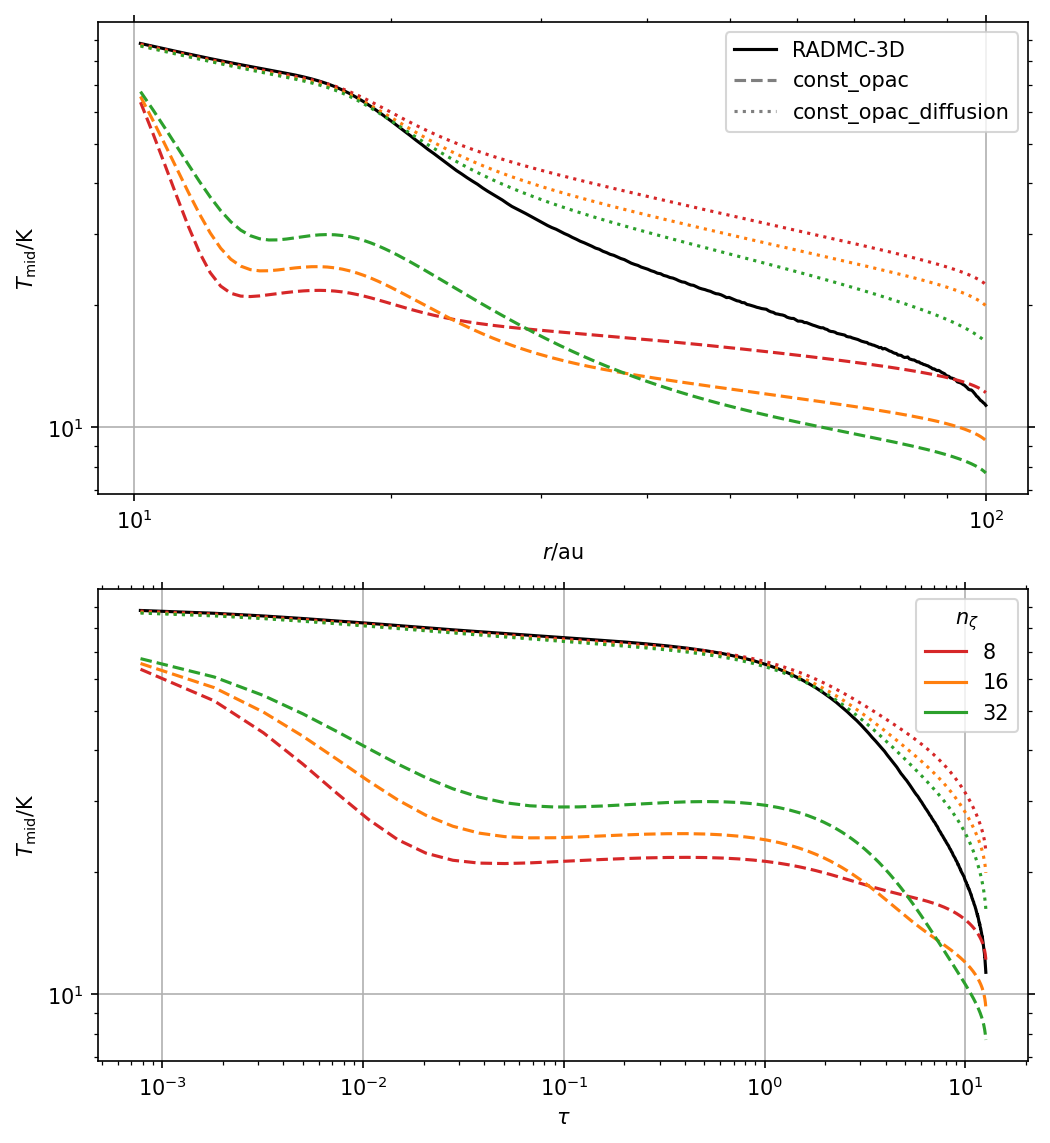

In [1]:
#===============================================================================
import matplotlib.pyplot as plt
import numpy as np
from radmc3dPy import *
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

fig, axs = plt.subplots(nrows=2, figsize=(8, 9), dpi=150)
tab_colors = ['tab:red', 'tab:orange', 'tab:green']
linestyles = ['dashed', 'dotted']
data = analyze.readData(ddens=True, dtemp=True)
j_mid = 256

data.getTau(wav=0.5) # tau = 1 surface
axs[0].plot(data.grid.x/natconst.au, data.dusttemp[:,j_mid,0,0], 'black',
            label='RADMC-3D')
axs[1].plot(data.taux[:,j_mid,0], data.dusttemp[:,j_mid,0,0], 'black')

base = '/home/stanley/github/sabaronett/rad-hydro/athena/dev'
problem_ids = ['const_opac', 'const_opac_diffusion']
nzetas = [8, 16, 32]

for p, pid in enumerate(problem_ids):
    for z, nzeta in enumerate(nzetas):
        path = f'{base}/{pid}/nzeta{nzeta}'
        athinput = athena_read.athinput(f'{path}/athinput.{pid}')
        L_0 = athinput['radiation']['length_unit']
        T_0 = athinput['radiation']['T_unit']
        dr = (athinput['mesh']['x1max'] - athinput['mesh']['x1min'])\
             /athinput['mesh']['nx1']
        athdf = athena_read.athdf(f'{path}/athdf/{pid}.out1.00001.athdf')
        dtau = athdf['Sigma_a_0'][0]*dr
        tau_field  = np.cumsum(dtau, axis=1)
        T_field = athdf['press'][0][j_mid]/athdf['rho'][0][j_mid]

        axs[0].plot(athdf['x1v']*L_0/natconst.au, T_field*T_0, tab_colors[z],
                    linestyle=linestyles[p])
        axs[1].plot(tau_field[j_mid], T_field*T_0, tab_colors[z],
                    linestyle=linestyles[p])
        
        # Plot ghost points for color legend
        if p == 0:
            axs[1].plot([], [], tab_colors[z], label=f'{nzeta}')
    
    # Plot ghost points for linestyle legend
    axs[0].plot([], [], 'tab:gray', linestyle=linestyles[p],
                label=f'{pid}')

# Format (sub)plots
for ax in axs:
    ax.grid()
    ax.minorticks_on()
    ax.set(ylabel=r'$T_\mathrm{mid}$/K', yscale='log', xscale='log',)
    ax.tick_params(axis='both', which='both', top=True, right=True)

axs[0].legend()
axs[0].set(xlabel=r'$r$/au')
axs[1].legend(title=r'$n_\zeta$')
axs[1].set(xlabel=r'$\tau$')
plt.subplots_adjust(hspace=0.2)